In [1]:
from typing import Callable, Union, List
from functools import reduce
import optuna
from torchvision import transforms
from torchvision.transforms import AugMix, Compose
from transformers.fourier_transformer import FourierTransformer
from transformers.jigsaw_transformer import JigsawTransform
from transformers.style_transformer import StyleTransformer
from config import MAX_EPOCHS, BATCH_SIZE, PATIENCE
import os
from torchvision.transforms import InterpolationMode
from tqdm import tqdm
import pandas as pd
from torch import load, nn
from models import get_resnet_18, get_resnet_50, _do_eval, get_criterion
from transformers.transformation_utils import get_transform_pipeline
from dataset_utils import all_datasets, split_df
from utils import split_df_into_loaders
from cuda import device

dataset = all_datasets["pacs"]
target_domain = "sketch"


train_loader, _, test_loader, _ = split_df_into_loaders(
    df=dataset["df"], target_domain=target_domain
)

RANDOM SEED: 42


In [2]:
AUGMENTATION_HYPERPARAMS = {
    "USE_AUGMIX": False,
    "SEVERITY": 3,
    "MIXTURE_WIDTH": 4,
    "CHAIN_DEPTH": 4,
    "ALPHA": 0.1,
    "ALL_OPS": True,
    "INTERPOLATION": InterpolationMode.NEAREST,
    # Fourier params
    "USE_FOURIER": False,
    "SQUARE_SIZE": 4,
    "ETA": 0.5,
    # Jigsaw params
    "USE_JIGSAW": False,
    "MIN_GRID_SIZE": 2,
    "MAX_GRID_SIZE": 6,
    # Dlow params
    "USE_DLOW": True,
    # Order params
    "TRANSFORMATIONS_ORDER": ("Jigsaw", "Augmix", "Dlow", "Fourier"),
    "TARGET_DOMAIN": "sketch",
}

transformation_pipeline = get_transform_pipeline(params=AUGMENTATION_HYPERPARAMS)

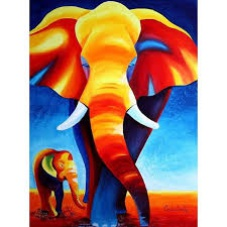

In [3]:
from dataset_utils import to_pil

batch, _ = next(iter(train_loader))
sample = batch[0]
to_pil(sample)

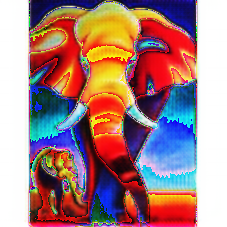

In [4]:
to_pil(transformation_pipeline(batch)[0])

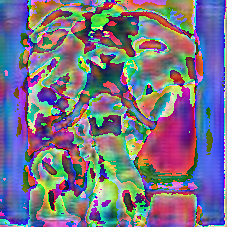

In [6]:
out = transforms.Compose(
    [
        StyleTransformer(
            ckpt_dir="dlow/checkpoints/",
            target_domain=target_domain,
        )
    ]
)(batch)

to_pil(out[0])